# Imports

In [179]:
import os
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from joypy import joyplot

from src.permutation.loader import CSVLoader

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR


import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

naive_features = [
    "RADIUS",
    "LENGTH",
    "WALL",
    "SHEAR",
    "CIRCUM",
    "FLOW",
    "NODES",
    "EDGES",
    "GRADIUS",
    "GDIAMETER",
    "AVG_ECCENTRICITY",
    "AVG_SHORTEST_PATH",
    "AVG_IN_DEGREES",
    "AVG_OUT_DEGREES",
    "AVG_DEGREE",
    "AVG_CLUSTERING",
    "AVG_CLOSENESS",
    "AVG_BETWEENNESS",
    "AVG_CORENESS"]

topo_features = naive_features + [
    "GRADIUS:FLOW",
    "GDIAMETER:FLOW",
    "AVG_ECCENTRICITY:FLOW",
    "AVG_SHORTEST_PATH:FLOW",
    "AVG_CLOSENESS:FLOW",
    "AVG_BETWEENNESS:FLOW",
    "GRADIUS:WALL",
    "GDIAMETER:WALL",
    "AVG_ECCENTRICITY:WALL",
    "AVG_SHORTEST_PATH:WALL",
    "AVG_CLOSENESS:WALL",
    "AVG_BETWEENNESS:WALL",
    "GRADIUS:SHEAR",
    "GDIAMETER:SHEAR",
    "AVG_ECCENTRICITY:SHEAR",
    "AVG_SHORTEST_PATH:SHEAR",
    "AVG_CLOSENESS:SHEAR",
    "AVG_BETWEENNESS:SHEAR",
    "GRADIUS:RADIUS",
    "GDIAMETER:RADIUS",
    "AVG_ECCENTRICITY:RADIUS",
    "AVG_SHORTEST_PATH:RADIUS",
    "AVG_CLOSENESS:RADIUS",
    "AVG_BETWEENNESS:RADIUS",
    "GRADIUS:PRESSURE_AVG",
    "GDIAMETER:PRESSURE_AVG",
    "AVG_ECCENTRICITY:PRESSURE_AVG",
    "AVG_SHORTEST_PATH:PRESSURE_AVG",
    "AVG_CLOSENESS:PRESSURE_AVG",
    "AVG_BETWEENNESS:PRESSURE_AVG",
    "GRADIUS:PRESSURE_DELTA",
    "GDIAMETER:PRESSURE_DELTA",
    "AVG_ECCENTRICITY:PRESSURE_DELTA",
    "AVG_SHORTEST_PATH:PRESSURE_DELTA",
    "AVG_CLOSENESS:PRESSURE_DELTA",
    "AVG_BETWEENNESS:PRESSURE_DELTA",
    "GRADIUS:OXYGEN_AVG",
    "GDIAMETER:OXYGEN_AVG",
    "AVG_ECCENTRICITY:OXYGEN_AVG",
    "AVG_SHORTEST_PATH:OXYGEN_AVG",
    "AVG_CLOSENESS:OXYGEN_AVG",
    "AVG_BETWEENNESS:OXYGEN_AVG",
    "GRADIUS:OXYGEN_DELTA",
    "GDIAMETER:OXYGEN_DELTA",
    "AVG_ECCENTRICITY:OXYGEN_DELTA",
    "AVG_SHORTEST_PATH:OXYGEN_DELTA",
    "AVG_CLOSENESS:OXYGEN_DELTA",
    "AVG_BETWEENNESS:OXYGEN_DELTA",
]

spatial_features = topo_features + [
    "AVG_ECCENTRICITY_WEIGHTED",
    "AVG_CLOSENESS_WEIGHTED",
    "AVG_CORENESS_WEIGHTED",
    "AVG_BETWEENNESS_WEIGHTED",
    "AVG_OUT_DEGREES_WEIGHTED",
    "AVG_IN_DEGREES_WEIGHTED",
    "AVG_DEGREE_WEIGHTED",
    "GRADIUS:INVERSE_DISTANCE",
    "GDIAMETER:INVERSE_DISTANCE",
    "AVG_ECCENTRICITY:INVERSE_DISTANCE",
    "AVG_SHORTEST_PATH:INVERSE_DISTANCE",
    "AVG_CLOSENESS:INVERSE_DISTANCE",
    "AVG_BETWEENNESS:INVERSE_DISTANCE",
]

In [ ]:
def get_hparams(feature_type, context, response, model, tp, temporal_flag=False, qt_flag=False, synthetic=False, diff_flag=False):
    # Loads optimal hyperparameters for a given model
    if qt_flag:
        path = os.path.join("stored_results", "quantity_experiments")
    elif temporal_flag:
        path = os.path.join("stored_results", "temporal")
    elif synthetic:
        path = os.path.join("stored_results", "synthetic")
    else:
        path = "stored_results"

    for exp_folder in os.listdir(path):
        chunks = exp_folder.split("_")
        if len(chunks) < 4:
            continue
        
        if not chunks[0] == feature_type:
            continue
        
        if not chunks[3] == "15":
            continue
        
        if not diff_flag:
            if not chunks[1] == str(int(tp)):
                continue
        else:
            if not chunks[1] == f"0-{tp}":
                continue

        if not chunks[4] == context:
            continue

        try:    
            if chunks[5] != "0713":
                continue 
        except:
            pass
        
        print(exp_folder)
        for resp_folder in os.listdir(os.path.join(path, exp_folder)):
            if response not in resp_folder:
                continue
            
            
            full_path = os.path.join(path, exp_folder, resp_folder, model)
            for file in os.listdir(full_path):
                if not file.endswith(".json"):
                    continue

                hparams = json.load(open(os.path.join(full_path, file), "r"))
                return hparams

In [180]:
context_list = ["C", "CH"]
response_list = ["ACTIVITY", "GROWTH", "SYMMETRY"]
# context_list = ["C"]
# response_list = ["ACTIVITY"]
model_list = ["MLR", "RF", "SVR", "MLP"]

In [ ]:
# Print hyperparameters
def insert_backslash_before_underscore(input_string):
    return input_string.replace('_', r'\_')

feature_sets = ["naive", "topo", "spatial"]

for context in context_list:
    for model in model_list:
        for response in response_list:
            print(f"---{context} {response} {model}---")
            for feature in feature_sets:
            
                hparams = get_hparams(feature, context, response, model)

                if feature == "naive":
                    f = "Topological"
                elif feature == "topo":
                    f = "Hemodynamic"
                else:
                    f = "Spatial"

                keys = list(hparams.keys())
                for i in range(len(keys)):
                    key = keys[i]
                    key = insert_backslash_before_underscore(key)                    
                    if i == 0:
                        print(f"\\texttt{{ {model} }} & {response.title()} & \\multirow{{3}}{{*}}\\texttt{{ {f} }} & {key} & {hparams[keys[i]]} \\\\")
                    else:
                        print(f" & & & {key} & {hparams[keys[i]]} \\\\")
                    



# Temporal

In [ ]:
feature = "topo"
timepoints = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

temporal_df = pd.DataFrame(columns=["feature", "timepoint", "context", "response", "model", "train_r2_se", "test_r2_se", "train_r2_mean", "test_r2_mean", "train_rmse_se", "test_rmse_se", "train_rmse_mean", "test_rmse_mean"])

for context in context_list:
    for tp in timepoints:
        tp = float(tp)
        data_path = f"data/ARCADE/{context}-feature_{tp}_metric_15-04032023.csv"
        for response in response_list:
            loader = CSVLoader(data_path, features=topo_features, response=response, stratify="LAYOUT")
            loader.clean_data()

            for model in model_list:
                hparams = get_hparams(feature, context, response, model, tp)

                print(f"Running {model} on {context} {response} {tp}")
                print(f"Hyperparameters: {hparams}")

                if model == "MLR":
                    regressor = ElasticNet(**hparams)
                elif model == "MLP":
                    regressor = MLPRegressor(**hparams)
                elif model == "RF":
                    regressor = RandomForestRegressor(**hparams)
                elif model == "SVR":
                    if hparams.get("kernel") is not None:
                        regressor = SVR(**hparams)
                    else:
                        regressor = LinearSVR(**hparams)
                
                pipeline = Pipeline([
                    ("scaler", StandardScaler()),
                    ("regressor", regressor)
                ])

                train_r2s = []
                test_r2s = []
                train_rmses = []
                test_rmses = []
                for i in range(10):
                    loader.subsample(loader.n_total)
                    X_train, y_train = loader.load_training_data()
                    X_test, y_test = loader.load_testing_data()
                    pipeline.fit(X_train, y_train)

                    train_r2s.append(pipeline.score(X_train, y_train))
                    test_r2s.append(pipeline.score(X_test, y_test))
                    train_rmses.append(np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
                    test_rmses.append(np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

                train_r2_mean = np.mean(train_r2s)
                test_r2_mean = np.mean(test_r2s)
                train_r2_se = np.std(train_r2s) / np.sqrt(len(train_r2s))
                test_r2_se = np.std(test_r2s) / np.sqrt(len(test_r2s))

                train_rmse_mean = np.mean(train_rmses)
                test_rmse_mean = np.mean(test_rmses)
                train_rmse_se = np.std(train_rmses) / np.sqrt(len(train_rmses))
                test_rmse_se = np.std(test_rmses) / np.sqrt(len(test_rmses))


                print(f"Train R2: {train_r2_mean} Test R2: {test_r2_mean}")
                print(f"Train RMSE: {train_rmse_mean} Test RMSE: {test_rmse_mean}\n")

                temporal_df = temporal_df.append({
                    "feature": feature,
                    "timepoint": int(tp),
                    "context": context,
                    "response": response,
                    "model": model,
                    "train_r2_se": train_r2_se,
                    "train_r2_mean": train_r2_mean,
                    "train_r2s": train_r2s,
                    "test_r2_se": test_r2_se,
                    "test_r2s": test_r2s,
                    "test_r2_mean": test_r2_mean,
                    "train_rmse_mean": train_rmse_mean,
                    "train_rmses": train_rmses,
                    "test_rmse_mean": test_rmse_mean,
                    "test_rmses": test_rmses,
                    "train_rmse_se": train_rmse_se,
                    "test_rmse_se": test_rmse_se
                }, ignore_index=True)

temporal_df.to_csv("temporal.csv", index=False)

# Bar

In [167]:
bar_df = pd.DataFrame(columns=["timepoint", "set","model","context","response","feature", "r2", "r2_se", "rmse", "rmse_se"])

feature_sets = ["naive", "topo", "spatial"]
# feature_sets = ["topo"]
# feature_sets = ["diff"]

# timepoints = [0, 8, 15]
timepoints = [0]
for context in context_list:
    for tp in timepoints:
        tp_float = float(tp)
        data_path = f"data/ARCADE/{context}-feature_{tp_float}_metric_15-04032023.csv"
        # data_path = f"data/ARCADE/{context}-feature_8.0_metric_15-04032023.csv"
        print(data_path)
        # data_path = f"data/ARCADE/diff/{context}-feature_({tp_float}-0.0)_metric_15-04032023.csv"
        for feature in feature_sets:
            if feature == "spatial":
                features = spatial_features 
            elif feature == "topo" or feature == "diff":
                features = topo_features
            elif feature == "naive":
                features = naive_features

            for response in response_list:
                loader = CSVLoader(data_path, features=features, response=response, stratify="LAYOUT")
                loader.clean_data()

                for model in model_list:                    
                    print(f"Running {model} on {context} {response} {tp} with {feature} features")
                    hparams = get_hparams(feature, context, response, model, tp=tp)
                    print(f"Hyperparameters: {hparams}")

                    
                    sets = ["TRAIN", "TEST"]
                    test_r2s = []
                    train_r2s = []
                    test_rmses = []
                    train_rmses = []
                    for i in range(10):
                        if model == "MLR":
                            regressor = ElasticNet(**hparams)
                        elif model == "MLP":
                            regressor = MLPRegressor(**hparams)
                        elif model == "RF":
                            regressor = RandomForestRegressor(**hparams)
                        elif model == "SVR":
                            if hparams.get("kernel") is None:
                                regressor = LinearSVR(**hparams)
                            else:
                                regressor = SVR(**hparams)
                        pipeline = Pipeline([
                            ("scaler", StandardScaler()),
                            ("regressor", regressor)
                        ])
                        loader.subsample(loader.n_total, "LAYOUT")
                        X_train, y_train = loader.load_training_data()
                        X_test, y_test = loader.load_testing_data()
                        pipeline.fit(X_train, y_train)

                        train_r2s.append(pipeline.score(X_train, y_train))
                        test_r2s.append(pipeline.score(X_test, y_test))
                        train_rmses.append(np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
                        test_rmses.append(np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

                    train_r2_mean = np.mean(train_r2s)
                    test_r2_mean = np.mean(test_r2s)
                    train_r2_se = np.std(train_r2s) / np.sqrt(len(train_r2s))
                    test_r2_se = np.std(test_r2s) / np.sqrt(len(test_r2s))

                    train_rmse_mean = np.mean(train_rmses)
                    test_rmse_mean = np.mean(test_rmses)
                    train_rmse_se = np.std(train_rmses) / np.sqrt(len(train_rmses))
                    test_rmse_se = np.std(test_rmses) / np.sqrt(len(test_rmses))


                    print(f"Train: {train_r2_mean} Test: {test_r2_mean}")
                    print(test_r2s)

                    for set in sets:
                        if set == "TRAIN":
                            bar_df = bar_df.append({
                                "timepoint" : tp,
                                "set": "TRAIN",
                                "model": model,
                                "context": context,
                                "response": response,
                                "feature": feature,
                                "r2": train_r2_mean,
                                "r2_se": train_r2_se,
                                "r2s": train_r2s,
                                "rmse": train_rmse_mean,
                                "rmse_se": train_rmse_se
                            }, ignore_index=True)

                        elif set == "TEST":
                            bar_df = bar_df.append({
                                "timepoint" : tp,
                                "set": "TEST",
                                "model": model,
                                "context": context,
                                "response": response,
                                "feature": feature,
                                "r2": test_r2_mean,
                                "r2_se": test_r2_se,
                                "r2s": test_r2s,
                                "rmse": test_rmse_mean,
                                "rmse_se": test_rmse_se
                            }, ignore_index=True)

bar_df.to_csv("bar_r2_points0.csv", index=False)

data/ARCADE/C-feature_0.0_metric_15-04032023.csv
Running MLR on C ACTIVITY 0 with naive features
naive_0_metric_15_C
Hyperparameters: {'alpha': 0.0010000000000000002, 'l1_ratio': 0.1, 'max_iter': 10000}
Train: 0.2272123080275849 Test: 0.12383777389242848
[0.12615366054596933, 0.18119360308731092, 0.1125899660192593, 0.17044734874189738, 0.043629490578808605, 0.05773820653268702, 0.1698344472687674, 0.16628710408205716, 0.1871462736649232, 0.023357638402604297]
Running RF on C ACTIVITY 0 with naive features
naive_0_metric_15_C
Hyperparameters: {'n_estimators': 13, 'max_features': 0.1778279410038923, 'max_depth': 38, 'min_samples_split': 0.017782794100389243, 'min_samples_leaf': 0.017782794100389243, 'bootstrap': True}
Train: 0.5069369753257956 Test: 0.23388268038837529
[0.2687941506004634, 0.24265498679652975, 0.2631802199233101, 0.18224623657188188, 0.2983796778321889, 0.2540026053689901, 0.2187519020906571, 0.22746622359319868, 0.192354619838897, 0.19099618126763607]
Running SVR on C 

In [182]:
# Get best performing model for each response and context
df = pd.read_csv("bar_r2_points0.csv")
df_best = pd.DataFrame(columns=["set","model","context","response","feature","r2","r2_se","rmse","rmse_se","timepoint","emulator"])

for context in context_list:
    for response in response_list:
        best_model = df[(df["context"] == context) & (df["response"] == response) & (df["set"] == "TEST") & (df["timepoint"] == 0)].sort_values(by="rmse", ascending=True).iloc[0]
        print(f"{context},{response}: {best_model['model']} {best_model['feature']} {best_model['rmse']}")
        df_best = df_best.append({
            "set": "TEST",
            "model": best_model["model"],
            "context": context,
            "response": response,
            "feature": best_model["feature"],
            "r2": best_model["r2"],
            "r2_se": best_model["r2_se"],
            "rmse": best_model["rmse"],
            "rmse_se": best_model["rmse_se"],
            "timepoint": 0,
            "emulator": "ml",
        }, ignore_index=True)


print("----------")
df_naive = pd.read_csv("rnn/results-naive-072323.csv")
df_topo = pd.read_csv("rnn/results-topo-072323.csv")
df_spatial = pd.read_csv("rnn/results-spatial-072323.csv")
for context in context_list:
    for response in response_list:
        best_model_naive = df_naive[(df_naive["context"] == context) & (df_naive["response"] == response)].sort_values(by="test_rmse", ascending=True).iloc[0]
        best_model_topo = df_topo[(df_topo["context"] == context) & (df_topo["response"] == response)].sort_values(by="test_rmse", ascending=True).iloc[0]
        best_model_spatial = df_spatial[(df_spatial["context"] == context) & (df_spatial["response"] == response)].sort_values(by="test_rmse", ascending=True).iloc[0]

        # Pick the one with the lowest test RMSE
        best_model = min([best_model_naive, best_model_topo, best_model_spatial], key=lambda x: x["test_rmse"])
        df_best = df_best.append({
            "set": "TEST",
            "model": best_model["model"],
            "context": context,
            "response": response,
            "feature": best_model["feature"],
            "r2": best_model["test_r2"],
            "r2_se": 0,
            "rmse": best_model["test_rmse"],
            "rmse_se": 0,
            "timepoint": 0,
            "emulator": "rnn",
        }, ignore_index=True)
        print(f"{context},{response}: {best_model['model']} {best_model['feature']} {best_model['test_rmse']}")

df_best.to_csv("rnn_bar.csv", index=False)

C,ACTIVITY: RF topo 0.3125539737240869
C,GROWTH: RF spatial 0.1825715058914658
C,SYMMETRY: MLP naive 0.0805083082104911
CH,ACTIVITY: MLR topo 0.3120306532254241
CH,GROWTH: MLP spatial 0.2976064133999964
CH,SYMMETRY: MLR topo 0.1491707426762243
----------
C,ACTIVITY: MLP naive 0.321699100503053
C,GROWTH: SVR topo 0.1863076139961655
C,SYMMETRY: MLR naive 0.0761029734972782
CH,ACTIVITY: RF spatial 0.3149920590899034
CH,GROWTH: MLP spatial 0.3454817651325745
CH,SYMMETRY: MLP naive 0.155784140958515


# Quantity

In [ ]:
quant_df = pd.DataFrame(columns=["feature", "timepoint", "context", "response", "model", "num_observations", "train_r2_se", "test_r2_se", "train_r2_mean", "test_r2_mean", "train_rmse_se", "test_rmse_se", "train_rmse_mean", "test_rmse_mean"])

feature_sets = ["topo"]

timepoints = [8]
for context in context_list:
    for tp in timepoints:
        tp_float = float(tp)
        # data_path = f"data/ARCADE/{context}-feature_{tp_float}_metric_15-04032023.csv"
        data_path = f"data/ARCADE/{context}-feature_0.0_metric_{tp}-04032023.csv"
        for feature in feature_sets:
            if feature == "spatial":
                features = spatial_features 
            elif feature == "topo":
                features = topo_features
            elif feature == "naive":
                features = naive_features

            for response in response_list:
                loader = CSVLoader(data_path, features=features, response=response, stratify="LAYOUT")
                loader.clean_data()
                
                training_size_arr = np.linspace(50, loader.n_total, num=10, dtype=int)
                for data_size in training_size_arr:
                    for model in model_list:
                        hparams = get_hparams(feature, context, response, model, tp=tp, qt_flag=True)

                        print(f"Running {model} on {context} {response} {tp} ({data_size} samples)")
                        print(f"Hyperparameters: {hparams}")

                        if model == "MLR":
                            regressor = ElasticNet(**hparams)
                        elif model == "MLP":
                            regressor = MLPRegressor(**hparams)
                        elif model == "RF":
                            regressor = RandomForestRegressor(**hparams)
                        elif model == "SVR":
                            if hparams["kernel"] == "linear":
                                hparams.pop("kernel")
                                regressor = LinearSVR(**hparams)
                            else:
                                regressor = SVR(**hparams)
                        
                        pipeline = Pipeline([
                            ("scaler", StandardScaler()),
                            ("regressor", regressor)
                        ])

                        train_r2s = []
                        test_r2s = []
                        train_rmses = []
                        test_rmses = []
                        for i in range(10):
                            
                            loader.subsample(data_size)
                            
                            X_train, y_train = loader.load_training_data()
                            pipeline.fit(X_train, y_train)
                            X_test, y_test = loader.load_testing_data()

                            train_r2s.append(pipeline.score(X_train, y_train))
                            test_r2s.append(pipeline.score(X_test, y_test))
                            train_rmses.append(np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
                            test_rmses.append(np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

                        train_r2_mean = np.mean(train_r2s)
                        test_r2_mean = np.mean(test_r2s)
                        train_r2_se = np.std(train_r2s) / np.sqrt(len(train_r2s))
                        test_r2_se = np.std(test_r2s) / np.sqrt(len(test_r2s))

                        train_rmse_mean = np.mean(train_rmses)
                        test_rmse_mean = np.mean(test_rmses)
                        train_rmse_se = np.std(train_rmses) / np.sqrt(len(train_rmses))
                        test_rmse_se = np.std(test_rmses) / np.sqrt(len(test_rmses))

                        print(f"Train R2: {train_r2_mean} Test R2: {test_r2_mean}")
                        print(f"Train RMSE: {train_rmse_mean} Test RMSE: {test_rmse_mean}\n")

                        quant_df = quant_df.append({
                            "feature": feature,
                            "timepoint": int(tp),
                            "context": context,
                            "response": response,
                            "model": model,
                            "num_observations": data_size,
                            "timepoint": tp,
                            "train_r2_se": train_r2_se,
                            "train_r2_mean": train_r2_mean,
                            "train_r2s": train_r2s,
                            "test_r2_se": test_r2_se,
                            "test_r2_mean": test_r2_mean,
                            "test_r2s": test_r2s,
                            "train_rmse_mean": train_rmse_mean,
                            "train_rmses": train_rmses,
                            "test_rmse_mean": test_rmse_mean,
                            "test_rmses" : test_rmses,
                            "train_rmse_se": train_rmse_se,
                            "test_rmse_se": test_rmse_se
                        }, ignore_index=True)

quant_df.to_csv("quant_8.csv", index=False)

# RNN

In [188]:
rnn_df = pd.DataFrame(columns=["set","model","context","response","feature", "r2", "r2_se", "rmse", "rmse_se"])

timepoints = [0]

model_map = {"MLR": "ElasticNet", "RF": "RandomForestRegressor", "SVR": "SVR", "MLP": "MLPRegressor"}
hparams_df = pd.read_csv("rnn.csv")

for row in hparams_df.iterrows():
    context = row[1]["context"]
    model = row[1]["model"]
    hparams = row[1]["hyperparameters"]
    model_params = eval(hparams)
    feature = row[1]["feature"]
    response = row[1]["response"]

    if feature == "spatial":
        features = spatial_features 
        if context == "C":
            remove_list = ['AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
        if context == "CH":
            remove_list = ['GRADIUS:FLOW', 'GDIAMETER:FLOW', 'AVG_ECCENTRICITY:FLOW', 'AVG_SHORTEST_PATH:FLOW', 'AVG_CLOSENESS:FLOW', 'AVG_BETWEENNESS:FLOW', 'AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
    elif feature == "topo":
        features = topo_features
        if context == "C":
            remove_list = ['AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
        if context == "CH":
            remove_list = ['GRADIUS:FLOW', 'GDIAMETER:FLOW', 'AVG_ECCENTRICITY:FLOW', 'AVG_SHORTEST_PATH:FLOW', 'AVG_CLOSENESS:FLOW', 'AVG_BETWEENNESS:FLOW', 'AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
    elif feature == "naive":
        features = naive_features
    features = [f for f in features if f not in remove_list]

    train_X_data_path = f"rnn/{feature}/TRAIN_{context}-synthetic_data-072323.csv"
    test_X_data_path = f"rnn/{feature}/TEST_{context}-synthetic_data-072323.csv"

    
            
    test_r2s = []
    train_r2s = []
    test_rmses = []
    train_rmses = []
    for i in range(10):
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("regressor", regressor)
        ])
        if model == "MLR":
            regressor = ElasticNet(**model_params)
        elif model == "MLP":
            regressor = MLPRegressor(**model_params)
        elif model == "RF":
            regressor = RandomForestRegressor(**model_params)
        elif model == "SVR":
            if model_params.get("kernel") is None:
                regressor = LinearSVR(**model_params)
            else:
                regressor = SVR(**model_params)
        X_train = pd.read_csv(train_X_data_path, usecols=features)
        X_test = pd.read_csv(test_X_data_path, usecols=features)
        y_train = pd.read_csv(train_X_data_path, usecols=[response])
        y_test = pd.read_csv(test_X_data_path, usecols=[response])
        pipeline.fit(X_train, y_train)

        train_r2s.append(pipeline.score(X_train, y_train))
        test_r2s.append(pipeline.score(X_test, y_test))
        train_rmses.append(np.sqrt(mean_squared_error(y_train, pipeline.predict(X_train))))
        test_rmses.append(np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))


    train_rmse_mean = np.mean(train_rmses)
    test_rmse_mean = np.mean(test_rmses)
    train_r2_mean = np.mean(train_r2s)
    test_r2_mean = np.mean(test_r2s)

    train_r2_se = np.std(train_r2s) / np.sqrt(len(train_r2s))
    test_r2_se = np.std(test_r2s) / np.sqrt(len(test_r2s))

    train_rmse_se = np.std(train_rmses) / np.sqrt(len(train_rmses))
    test_rmse_se = np.std(test_rmses) / np.sqrt(len(test_rmses))

    print(context, response, model, feature)
    print(test_rmse_mean)
    print(test_rmses)

    rnn_df = rnn_df.append({
        "set": "TEST",
        "timepoint" : tp,
        "model": model,
        "context": context,
        "response": response,
        "feature": feature,
        "r2": test_r2_mean,
        "r2_se": test_r2_se,
        "rmse": test_rmse_mean,
        "rmse_se": test_rmse_se
    }, ignore_index=True)

rnn_df.to_csv("rnn_r2_bar0.csv", index=False)

C ACTIVITY MLP naive
0.3282707023288615
[0.3902068485672615, 0.32143811988737453, 0.32131519535504316, 0.32126331850834594, 0.3213179832745212, 0.3216091917540057, 0.321295834946486, 0.32128471056258584, 0.3213740331919125, 0.3216017872410787]
C GROWTH SVR topo
0.18725934780611267
[0.19582495209547762, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323, 0.18630761399618323]
C SYMMETRY MLR naive
0.07622441417626154
[0.07731739321975978, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728, 0.07610297206031728]
CH ACTIVITY RF spatial
0.31916139545388866
[0.3186517273354827, 0.32062605984999343, 0.3201411665683054, 0.3148270942513122, 0.32078270545461346, 0.3209227083678873, 0.3212082232338859, 0.31772126142745444, 0.31720309891486187, 0.3195299091350898]
CH GROW

In [192]:
rnn_df = pd.DataFrame(columns=["context","set","feature","response","timepoint","y_true","emulator","model",'y_pred'])
timepoints = [0]

model_map = {"MLR": "ElasticNet", "RF": "RandomForestRegressor", "SVR": "SVR", "MLP": "MLPRegressor"}
hparams_df = pd.read_csv("rnn.csv")

for row in hparams_df.iterrows():
    context = row[1]["context"]
    model = row[1]["model"]
    hparams = row[1]["hyperparameters"]
    model_params = eval(hparams)
    feature = row[1]["feature"]
    response = row[1]["response"]
    print(f"{context} {response} {model} {feature}")

    if feature == "spatial":
        features = spatial_features 
        if context == "C":
            remove_list = ['AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
        if context == "CH":
            remove_list = ['GRADIUS:FLOW', 'GDIAMETER:FLOW', 'AVG_ECCENTRICITY:FLOW', 'AVG_SHORTEST_PATH:FLOW', 'AVG_CLOSENESS:FLOW', 'AVG_BETWEENNESS:FLOW', 'AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
    elif feature == "topo":
        features = topo_features
        if context == "C":
            remove_list = ['AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
        if context == "CH":
            remove_list = ['GRADIUS:FLOW', 'GDIAMETER:FLOW', 'AVG_ECCENTRICITY:FLOW', 'AVG_SHORTEST_PATH:FLOW', 'AVG_CLOSENESS:FLOW', 'AVG_BETWEENNESS:FLOW', 'AVG_BETWEENNESS:SHEAR', 'AVG_BETWEENNESS:PRESSURE_DELTA', 'AVG_BETWEENNESS:OXYGEN_DELTA', 'LAYOUT']
    elif feature == "naive":
        features = naive_features
    features = [f for f in features if f not in remove_list]

    train_X_data_path = f"rnn/{feature}/TRAIN_{context}-synthetic_data-072323.csv"
    test_X_data_path = f"rnn/{feature}/TEST_{context}-synthetic_data-072323.csv"

    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", regressor)
    ])
    if model == "MLR":
        regressor = ElasticNet(**model_params)
    elif model == "MLP":
        regressor = MLPRegressor(**model_params)
    elif model == "RF":
        regressor = RandomForestRegressor(**model_params)
    elif model == "SVR":
        if model_params.get("kernel") is None:
            regressor = LinearSVR(**model_params)
        else:
            regressor = SVR(**model_params)
    X_train = pd.read_csv(train_X_data_path, usecols=features)
    X_test = pd.read_csv(test_X_data_path, usecols=features)
    y_train = pd.read_csv(train_X_data_path, usecols=[response])
    y_test = pd.read_csv(test_X_data_path, usecols=[response])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

    
    # Add every point prediction to the dataframe for a parity plot
    for i, pred in enumerate(y_pred):
        rnn_df = rnn_df.append({
            "context" : context,
            "set": "TEST",
            "feature": "syntopo",
            "response": response,
            "timepoint":tp,
            "y_true": y_test.iloc[i].values[0],
            "y_pred": pred,
            "emulator": "rnn",
            "model": model
        }, ignore_index=True)

    for i, pred in enumerate(y_pred_train):
        rnn_df = rnn_df.append({
            "context" : context,
            "set": "TRAIN",
            "feature": "syntopo",
            "response": response,
            "timepoint":0,
            "y_true": y_train.iloc[i].values[0],
            "y_pred": pred,
            "emulator": "rnn",
            "model": model
        }, ignore_index=True)


rnn_df.to_csv("rnn_parity.csv", index=False)

C ACTIVITY MLP naive
C GROWTH SVR topo
C SYMMETRY MLR naive
CH ACTIVITY RF spatial
CH GROWTH MLP spatial
CH SYMMETRY MLP naive


# Non-normality 

In [ ]:
ridge_df = pd.read_csv("emergent.csv")
# Standardize response columns
ridge_df["ACTIVITY"] = (ridge_df["ACTIVITY"] - ridge_df["ACTIVITY"].mean()) / ridge_df["ACTIVITY"].std()
ridge_df["GROWTH"] = (ridge_df["GROWTH"] - ridge_df["GROWTH"].mean()) / ridge_df["GROWTH"].std()
ridge_df["SYMMETRY"] = (ridge_df["SYMMETRY"] - ridge_df["SYMMETRY"].mean()) / ridge_df["SYMMETRY"].std()

for response in response_list: 
    response_df = ridge_df[["time", response, "context"]]
    # Remove rows where time is 0
    response_df = response_df[response_df['time'] != 0]
    response_df = response_df[response_df['time'] != 1]

    df_c = response_df[response_df['context'] == 'C'].copy().reset_index(drop=True)
    df_c.drop(columns=["context"], inplace=True)
    df_c.rename(columns={response: "C"}, inplace=True)
    df_ch = response_df[response_df['context'] == 'CH'].copy().reset_index(drop=True)
    df_ch.drop(columns=["context"], inplace=True)
    df_ch.drop(columns=["time"], inplace=True)
    df_ch.rename(columns={response: "CH"}, inplace=True)

    df_combined = pd.concat([df_c, df_ch], axis=1, ignore_index=False)
    # convert time column to ints and then sort
    df_combined["time"] = df_combined["time"].astype(int)
    df_combined.sort_values(by=["time"], inplace=True)

    fig, axes = joyplot(
        data=df_combined,
        column=["C", "CH"],
        color=['#004c6d', '#FF2400'],
        by='time',
        figsize=(8, 12),
        linewidth=1.5
    )
    # Set x-axis limits for all axes and make tick marks bigger
    for ax in axes:
        ax.set_xlim(-2, 2)
        ax.tick_params(axis='x', which='major', labelsize=20)
        ax.tick_params(axis='y', which='major', labelsize=20)

    
    plt.show()
    plt.close()

In [ ]:
corr_df = pd.read_csv("emergent.csv")
cols = ["ACTIVITY", "GROWTH", "SYMMETRY", "time"]
df = ridge_df[cols]

df["ACTIVITY"] = (df["ACTIVITY"] - df["ACTIVITY"].mean()) / df["ACTIVITY"].std()
df["GROWTH"] = (df["GROWTH"] - df["GROWTH"].mean()) / df["GROWTH"].std()
df["SYMMETRY"] = (df["SYMMETRY"] - df["SYMMETRY"].mean()) / df["SYMMETRY"].std()

for context in 

# Compute the pairwise correlations
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Pairwise Correlation of ACTIVITY, GROWTH, SYMMETRY across Time")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Move new results

In [ ]:
import shutil

svr_path = "stored_results/svr_fix"
destination_path = "stored_results"

# Replace old SVR folder with new SVR folder
src_folders = []
dest_folders = []
for experiment_folder in os.listdir(svr_path):
    if ".DS_Store" in experiment_folder:
        continue

    for activity_folder in os.listdir(os.path.join(svr_path, experiment_folder)):
        if "CYCLES" in activity_folder:
            continue

        if ".DS_Store" in activity_folder:
            continue

        svr_folder = os.path.join(svr_path, experiment_folder, activity_folder, "SVR")
        if "topo" in experiment_folder:
            dest_folder = os.path.join(destination_path, "temporal", experiment_folder, activity_folder, "SVR")
        else:
            dest_folder = os.path.join(destination_path, experiment_folder, activity_folder, "SVR")

        src_folders.append(svr_folder)
        dest_folders.append(dest_folder)

# print(dest_folders)
# for i in range(len(src_folders)):
#     src = src_folders[i]
#     dest = dest_folders[i]
#     if os.path.exists(dest):
#         shutil.rmtree(dest)

#     shutil.move(src, dest)

# Statistical tests

In [117]:
import scipy.stats as stats
import math

pop_size = 10

def paired_t_test(mean1, sem1, n1, mean2, sem2, n2):
    # Calculate the standard deviation based on the standard error of the mean
    sd1 = sem1 * math.sqrt(n1)
    sd2 = sem2 * math.sqrt(n2)
    
    # Calculate the t-value in a paired t test
    mean_dif = mean1 - mean2
    sd_dif = math.sqrt((sd1 ** 2 + sd2 ** 2) / n1)
    t = mean_dif / sd_dif

    # Calculate the degrees of freedom
    df = n1 - 1

    # Calculate the p-value
    pval = stats.t.sf(np.abs(t), df) * 2

    return pval

df = pd.read_csv("rnn_r2_bar.csv")
df_test = df[df["set"] == "TEST"]

print(f"Alpha level = {0.05/6}")
for context in context_list:
    for response in response_list:
        df_filtered = df_test[df_test["context"] == context]
        df_filtered = df_filtered[df_filtered["response"] == response]
        print(f"{context} {response}")
        ml_row = df_filtered[df_filtered["emulator"] == "ml"]
        rnn_row = df_filtered[df_filtered["emulator"] == "rnn"]
        ml15_row = df_filtered[df_filtered["emulator"] == "ml15"]
        
        mean1 = ml_row["rmse"].values
        sem1 = ml_row["rmse_se"].values

        mean2 = rnn_row["rmse"].values
        sem2 = rnn_row["rmse_se"].values

        pval = paired_t_test(mean1, sem1, pop_size, mean2, sem2, pop_size)
        print(pval)


        mean1 = rnn_row["r2"].values
        sem1 = rnn_row["r2_se"].values

        mean2 = ml15_row["r2"].values
        sem2 = ml15_row["r2_se"].values

        pval = paired_t_test(mean1, sem1, pop_size, mean2, sem2, pop_size)
        print(pval)



Alpha level = 0.008333333333333333
C ACTIVITY


KeyError: 'emulator'

In [112]:
import ast
def parse_list_string(s):
    try:
        return s.strip('][').split(', ')
    except ValueError:
        return []

In [118]:
import scipy.stats as stats

pop_size = 10

tests = [["naive", "topo"], ["naive", "spatial"], ["topo", "spatial"]]

df = pd.read_csv("bar_r2_points8-15.csv")
df_test = df[df["set"] == "TEST"]

num_test = 0

for context in context_list:
    for response in response_list:
        df_filtered = df_test[df_test["context"] == context]
        df_filtered = df_filtered[df_filtered["response"] == response]

        print(f"{context} {response}")
        for test in tests:
            print(f"Testing: {test[0]}-{test[1]}")

            df1 = df_filtered[df_filtered["feature"] == test[0]]
            df2 = df_filtered[df_filtered["feature"] == test[1]]

            data1 = {
                "MLR": parse_list_string(df1[df1["model"] == "MLR"]["r2s"].values[0]),
                "MLP": parse_list_string(df1[df1["model"] == "MLP"]["r2s"].values[0]),
                "RF": parse_list_string(df1[df1["model"] == "RF"]["r2s"].values[0]),
                "SVR": parse_list_string(df1[df1["model"] == "SVR"]["r2s"].values[0])
            }

            data2 = {
                "MLR": parse_list_string(df2[df2["model"] == "MLR"]["r2s"].values[0]),
                "MLP": parse_list_string(df2[df2["model"] == "MLP"]["r2s"].values[0]),
                "RF": parse_list_string(df2[df2["model"] == "RF"]["r2s"].values[0]),
                "SVR": parse_list_string(df2[df2["model"] == "SVR"]["r2s"].values[0])
            }
            
            # One way ANOVA
            f_stat, p_value = stats.f_oneway(*data1.values(), *data2.values())
            print(f"p-value: {p_value}")
            num_test += 1


print(f"Significance level: {0.05/num_test}")
        
        

        

C ACTIVITY
Testing: naive-topo
p-value: 0.9229020339772519
Testing: naive-spatial
p-value: 0.586117478160537
Testing: topo-spatial
p-value: 0.8854494823690916
C GROWTH
Testing: naive-topo
p-value: 0.3652667735918061
Testing: naive-spatial
p-value: 0.34203280368626127
Testing: topo-spatial
p-value: 0.3743223257132838
C SYMMETRY
Testing: naive-topo
p-value: 0.14429836728925088
Testing: naive-spatial
p-value: 0.5007246178336733
Testing: topo-spatial
p-value: 0.04101334690698316
CH ACTIVITY
Testing: naive-topo
p-value: 0.014189614464353599
Testing: naive-spatial
p-value: 0.41301186359976017
Testing: topo-spatial
p-value: 0.8754237189161617
CH GROWTH
Testing: naive-topo
p-value: 1.9348044615453064e-05
Testing: naive-spatial
p-value: 6.104370507069326e-20
Testing: topo-spatial
p-value: 6.189863914185227e-14
CH SYMMETRY
Testing: naive-topo
p-value: 0.005649528225246394
Testing: naive-spatial
p-value: 9.803084789748319e-16
Testing: topo-spatial
p-value: 1.9278126280212793e-15
Significance leve

In [ ]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pop_size = 10

tests = [["naive", "topo"], ["naive", "spatial"], ["topo", "spatial"]]

df = pd.read_csv("bar_r2_points.csv")
df_test = df[df["set"] == "TEST"]

context_list = df_test["context"].unique()
response_list = df_test["response"].unique()

# Create an empty DataFrame to store the ANOVA results
anova_results = pd.DataFrame(columns=["context", "response", "feature", "model", "f_Value", "p_Value"])

for context in context_list:
    for response in response_list:
        df_filtered = df_test[df_test["context"] == context]
        df_filtered = df_filtered[df_filtered["response"] == response]

        print(f"{context} {response}")
        for test in tests:
            print(f"Testing: {test[0]}-{test[1]}")

            # Filter data for the two feature sets
            df_naive = df_filtered[df_filtered["feature"] == test[0]]
            df_topo = df_filtered[df_filtered["feature"] == test[1]]

            # Convert the "r2s" column from string to list of floats
            data_models1 = {
                "MLR": df_naive[df_naive["model"] == "MLR"]["r2s"].apply(parse_list_string),
                "RF": df_naive[df_naive["model"] == "RF"]["r2s"].apply(parse_list_string),
                "SVR": df_naive[df_naive["model"] == "SVR"]["r2s"].apply(parse_list_string),
                "MLP": df_naive[df_naive["model"] == "MLP"]["r2s"].apply(parse_list_string),
            }

            data_models2 = {
                "MLR": df_topo[df_topo["model"] == "MLR"]["r2s"].apply(parse_list_string),
                "RF": df_topo[df_topo["model"] == "RF"]["r2s"].apply(parse_list_string),
                "SVR": df_topo[df_topo["model"] == "SVR"]["r2s"].apply(parse_list_string),
                "MLP": df_topo[df_topo["model"] == "MLP"]["r2s"].apply(parse_list_string),
            }

            # Prepare the data for the two-way ANOVA
            data = []
            for feature_set, model_data in data_models1.items():
                data.extend(zip(model_data, [feature_set] * len(model_data), [test[0]] * len(model_data)))

            for feature_set, model_data in data_models2.items():
                data.extend(zip(model_data, [feature_set] * len(model_data), [test[1]] * len(model_data)))

            df_anova = pd.DataFrame(data, columns=["r2", "feature", "model"])
            df_anova["feature"] = df_anova["feature"].astype(str)
            df_anova["model"] = df_anova["model"].astype(str)

            # Explode the dataframe on the r2 column
            df_anova = df_anova.explode("r2")
            df_anova["r2"] = df_anova["r2"].astype(float)

            # Perform the two-way ANOVA
            formula = "r2 ~ C(feature) + C(model) + C(feature):C(model)"
            model = ols(formula, data=df_anova).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)

            f_value = anova_table["F"]["C(feature)"]
            p_value = anova_table["PR(>F)"]["C(feature)"]

            # Store the ANOVA results
            anova_results = anova_results.append(
                {
                    "context": context,
                    "response": response,
                    "feature": f"{test[0]}-{test[1]}",
                    "model": "All",
                    "f_Value": f_value,
                    "p_Value": p_value,
                },
                ignore_index=True,
            )

print(anova_results)

Significant data:


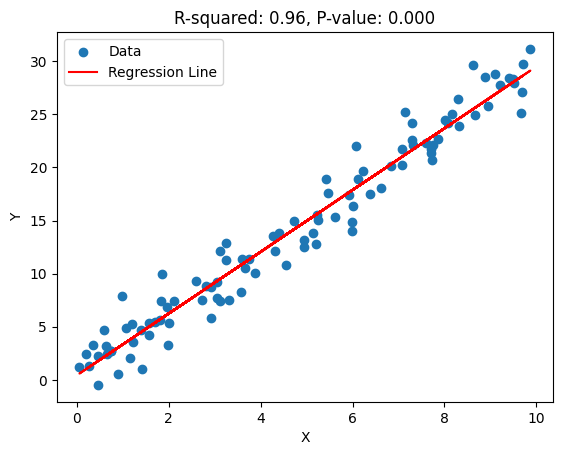

Non-significant data:


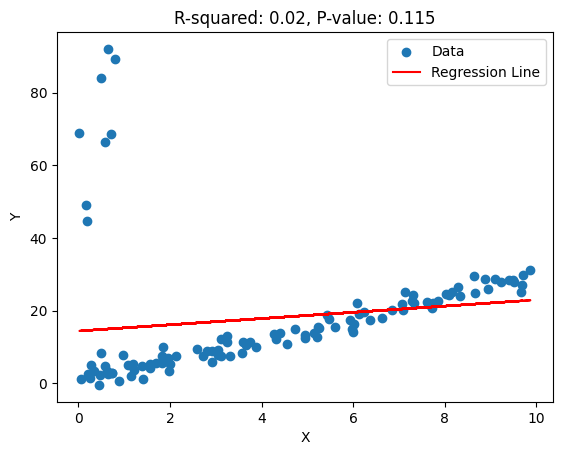

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Generate some sample data for demonstration
np.random.seed(42)
x = np.random.rand(100) * 10
y = 3 * x + np.random.randn(100) * 2

# Add some noise to make some data points not significant
x_noisy = np.concatenate((x, np.random.rand(10)))
y_noisy = np.concatenate((y, np.random.randn(10) * 20 + np.random.rand(10) * 100))

# Create a DataFrame for our data
data = pd.DataFrame({'X': x, 'Y': y})
data_noisy = pd.DataFrame({'X': x_noisy, 'Y': y_noisy})

# Function to perform linear regression and plot the results
def perform_linear_regression(data):
    X = data[['X']]
    y = data['Y']

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Get the predicted values and calculate the R-squared
    y_pred = model.predict(X)
    r_squared = model.score(X, y)

    # Use statsmodels to obtain p-value
    X = sm.add_constant(X)
    model_sm = sm.OLS(y, X).fit()
    p_value = model_sm.pvalues['X']

    # Plot the data points and the regression line
    plt.scatter(X['X'], y, label='Data')
    plt.plot(X['X'], y_pred, color='red', label='Regression Line')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'R-squared: {r_squared:.2f}, P-value: {p_value:.3f}')
    plt.legend()
    plt.show()

# Perform linear regression and plot for significant data
print("Significant data:")
perform_linear_regression(data)

# Perform linear regression and plot for non-significant data
print("Non-significant data:")
perform_linear_regression(data_noisy)

